In [1]:
import numpy as np 
import pandas as pd
import pyspark
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from pyspark.sql import SparkSession

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91347\AppData\Roaming\nltk_data...


In [2]:
covid=pd.read_csv('covid19_tweets.csv')
covid.head()

user_name         user_location  \
0           ᏉᎥ☻լꂅϮ            astroworld   
1    Tom Basile 🇺🇸          New York, NY   
2  Time4fisticuffs      Pewee Valley, KY   
3      ethel mertz  Stuck in the Middle    
4         DIPR-J&K     Jammu and Kashmir   

                                    user_description         user_created  \
0  wednesday addams as a disney princess keepin i...  2017-05-26 05:46:42   
1  Husband, Father, Columnist & Commentator. Auth...  2009-04-16 20:06:23   
2  #Christian #Catholic #Conservative #Reagan #Re...  2009-02-28 18:57:41   
3  #Browns #Indians #ClevelandProud #[]_[] #Cavs ...  2019-03-07 01:45:06   
4  🖊️Official Twitter handle of Department of Inf...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites  user_verified  \
0             624           950            18775          False   
1            2253          1677               24           True   
2            9275          9525             7254          False   
3             197           987             1488          False   
4          101009           168              101          False   

                  date                                               text  \
0  2020-07-25 12:27:21  If I smelled the scent of hand sanitizers toda...   
1  2020-07-25 12:27:17  Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2  2020-07-25 12:27:14  @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3  2020-07-25 12:27:10  @brookbanktv The one gift #COVID19 has give me...   
4  2020-07-25 12:27:08  25 July : Media Bulletin on Novel #CoronaVirus...   

                            hashtags               source  is_retweet  
0                                NaN   Twitter for iPhone       False  
1                                NaN  Twitter for Android       False  
2                        ['COVID19']  Twitter for Android       False  
3                        ['COVID19']   Twitter for iPhone       False  
4  ['CoronaVirusUpdates', 'COVID19']  Twitter for Android       False

In [80]:
covid=covid[['text','hashtags']]
covid['tag']=None
covid

C:\Users\91347\AppData\Local\Temp\ipykernel_29032\4039194746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid['tag']=None


text  \
0       If I smelled the scent of hand sanitizers toda...   
1       Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2       @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3       @brookbanktv The one gift #COVID19 has give me...   
4       25 July : Media Bulletin on Novel #CoronaVirus...   
...                                                   ...   
179103  Thanks @IamOhmai for nominating me for the @WH...   
179104  2020! The year of insanity! Lol! #COVID19 http...   
179105  @CTVNews A powerful painting by Juan Lucena. I...   
179106  More than 1,200 students test positive for #CO...   
179107  I stop when I see a Stop\n\n@SABCNews\n@Izinda...   

                                 hashtags   tag  
0                                     NaN  None  
1                                     NaN  None  
2                             ['COVID19']  None  
3                             ['COVID19']  None  
4       ['CoronaVirusUpdates', 'COVID19']  None  
...                                   ...   ...  
179103                      ['WearAMask']  None  
179104                        ['COVID19']  None  
179105                                NaN  None  
179106                        ['COVID19']  None  
179107                                NaN  None  

[179108 rows x 3 columns]

In [81]:
for i in range(covid.shape[0]):
    print(i)
    if covid.loc[i]['hashtags'] is not np.NaN:
            if 'COVID19' in  covid.loc[i]['hashtags']:
                covid.loc[i]['tag']=1
            else:
                covid.loc[i]['tag']=0    
    else:
        covid.loc[i]['tag']=0
covid

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

text  \
0       If I smelled the scent of hand sanitizers toda...   
1       Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2       @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3       @brookbanktv The one gift #COVID19 has give me...   
4       25 July : Media Bulletin on Novel #CoronaVirus...   
...                                                   ...   
179103  Thanks @IamOhmai for nominating me for the @WH...   
179104  2020! The year of insanity! Lol! #COVID19 http...   
179105  @CTVNews A powerful painting by Juan Lucena. I...   
179106  More than 1,200 students test positive for #CO...   
179107  I stop when I see a Stop\n\n@SABCNews\n@Izinda...   

                                 hashtags tag  
0                                     NaN   0  
1                                     NaN   0  
2                             ['COVID19']   1  
3                             ['COVID19']   1  
4       ['CoronaVirusUpdates', 'COVID19']   1  
...                                   ...  ..  
179103                      ['WearAMask']   0  
179104                        ['COVID19']   1  
179105                                NaN   0  
179106                        ['COVID19']   1  
179107                                NaN   0  

[179108 rows x 3 columns]

In [3]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
print(dataset.head())

   sentiment         ids                          date      flag  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [22]:
dataset['sentiment'].unique()

array([0, 1], dtype=int64)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


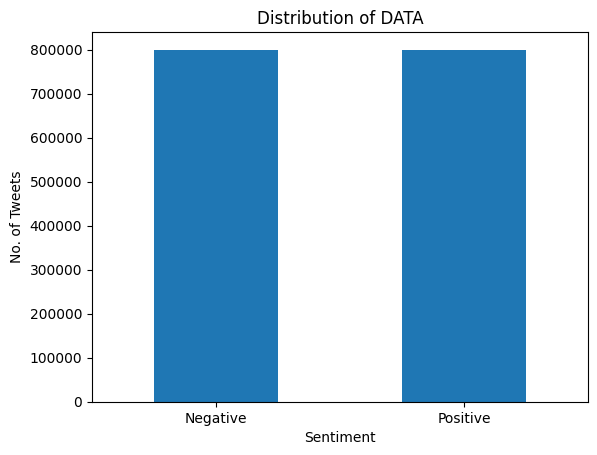

In [5]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
graph = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of DATA',
                                               legend=False)
graph.set_xticklabels(['Negative','Positive'], rotation=0)

graph.set_xlabel('Sentiment')
graph.set_ylabel('No. of Tweets')
# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [6]:
print(dataset)

         sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          1  Just woke up. Having no school is the best fee...
1599996          1  TheWDB.com - Very cool to hear old Walt interv...
1599997          1  Are you ready for your MoJo Makeover? Ask me f...
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]


In [7]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [8]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
#             if word not in stopwordlist:
                if len(word)>1:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [9]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Total Time taken for Preprocessing: {round(time.time()-t)}')

Total Time taken for Preprocessing: 86


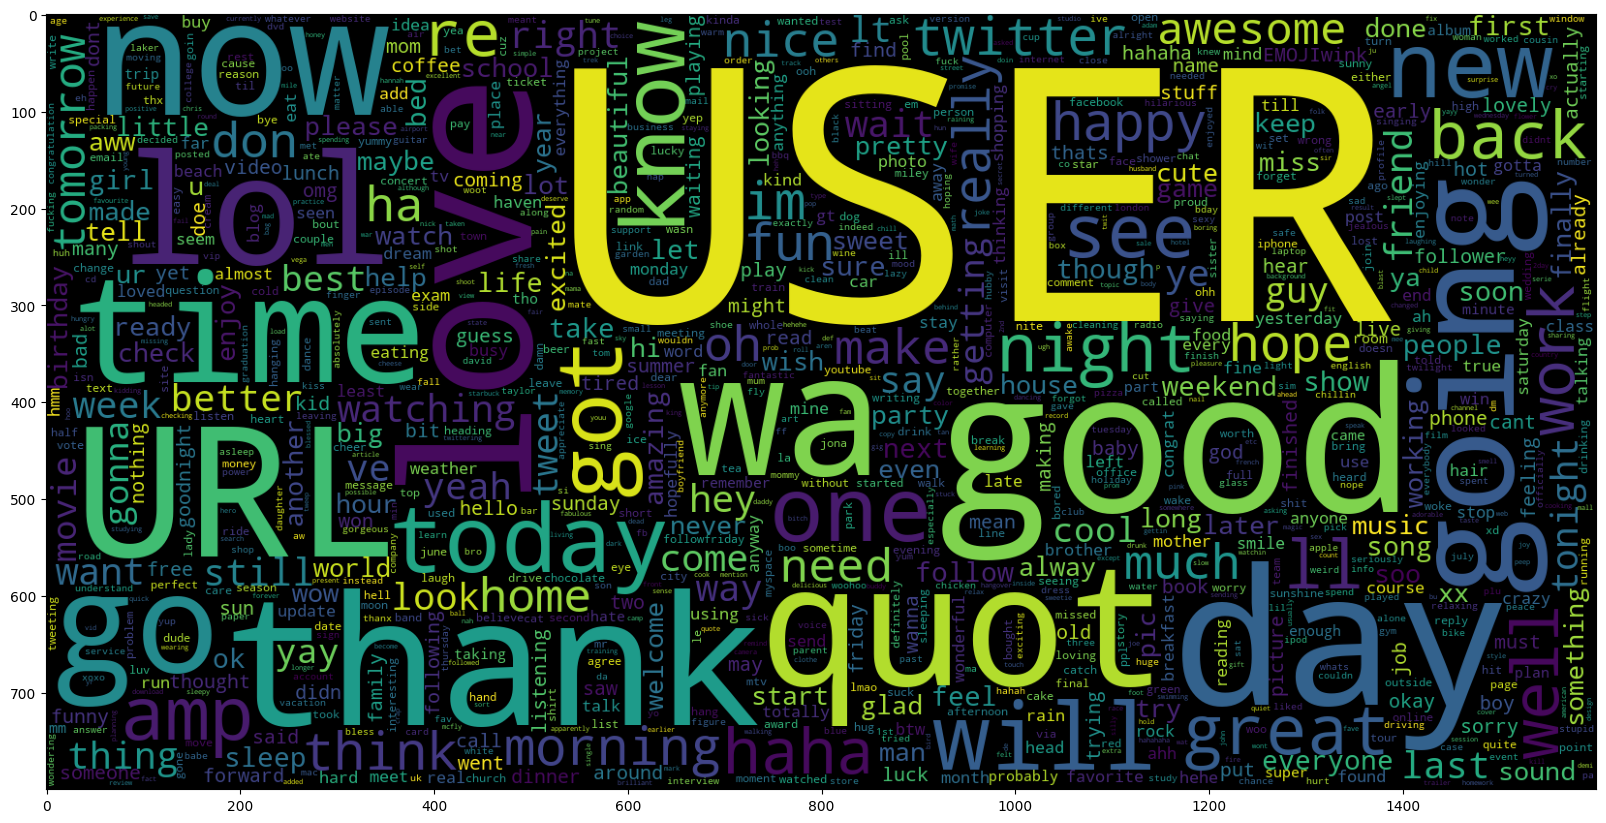

In [11]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

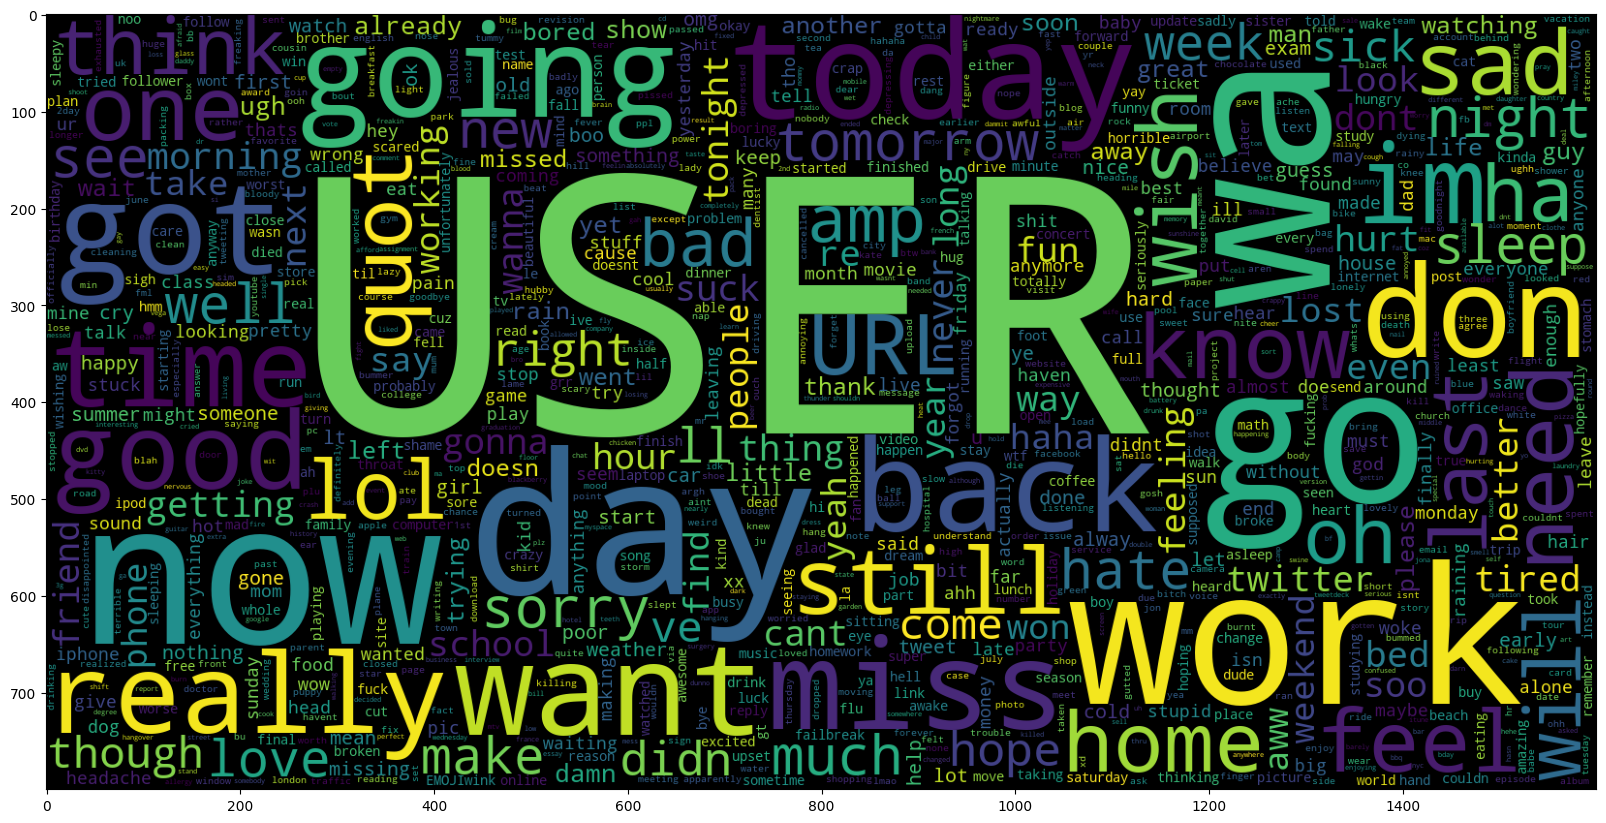

In [12]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

## Splitting the Data
The Preprocessed Data is divided into 2 sets of data: 

Training Data: The dataset upon which the model would be trained on. Contains 95% data.

Test Data: The dataset upon which the model would be tested against. Contains 5% data.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split Completed.')

Data Split Completed.


## TF-IDF Vectoriser


In [15]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectorizer fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectorizer fitted.
No. of feature_words:  500000


### Tranforming the dataset

In [16]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed According to vector.')


Data Transformed According to vector.


In [18]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Greens',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted ", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual "   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion ", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



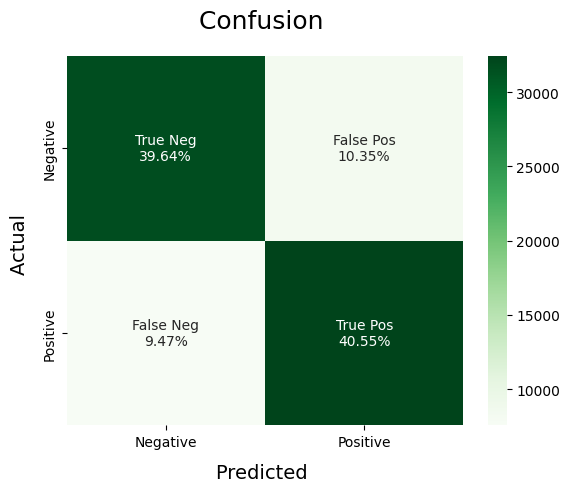

In [19]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



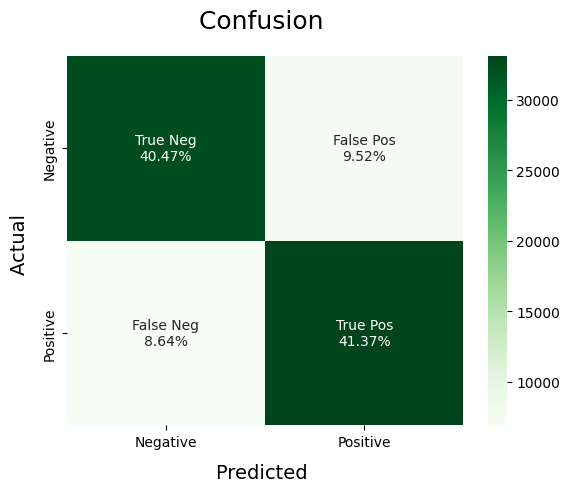

In [20]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



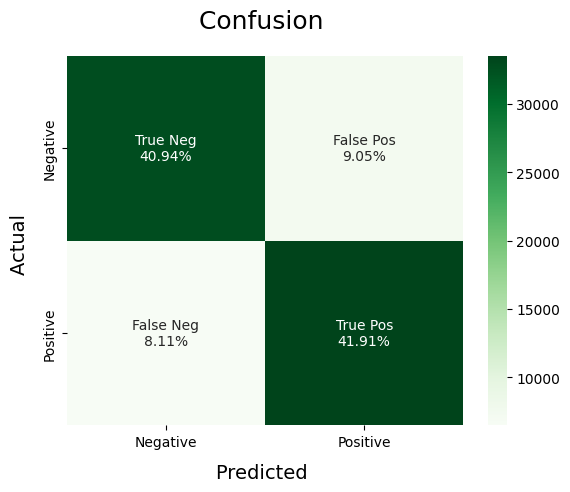

In [21]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

Overall, the best model is linear regression, save the model data of tfidf and linear regression

In [23]:
file = open('vectorizer.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

In [42]:
def load_models():
    
    # Load the vectoriser.
    file = open('vectorizer.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df




In [43]:
vectoriser, LRmodel = load_models()


In [82]:
ltext=list(covid['text'])
pred=predict(vectoriser, LRmodel, ltext)

In [83]:
pred=pred.replace({'Positive':1,'Negative':0})
pred

text  sentiment
0       If I smelled the scent of hand sanitizers toda...          1
1       Hey @Yankees @YankeesPR and @MLB - wouldn't it...          1
2       @diane3443 @wdunlap @realDonaldTrump Trump nev...          1
3       @brookbanktv The one gift #COVID19 has give me...          1
4       25 July : Media Bulletin on Novel #CoronaVirus...          1
...                                                   ...        ...
179103  Thanks @IamOhmai for nominating me for the @WH...          1
179104  2020! The year of insanity! Lol! #COVID19 http...          1
179105  @CTVNews A powerful painting by Juan Lucena. I...          0
179106  More than 1,200 students test positive for #CO...          1
179107  I stop when I see a Stop\n\n@SABCNews\n@Izinda...          1

[179108 rows x 2 columns]

In [85]:
covid['pred']=pred['sentiment']
covid

text  \
0       If I smelled the scent of hand sanitizers toda...   
1       Hey @Yankees @YankeesPR and @MLB - wouldn't it...   
2       @diane3443 @wdunlap @realDonaldTrump Trump nev...   
3       @brookbanktv The one gift #COVID19 has give me...   
4       25 July : Media Bulletin on Novel #CoronaVirus...   
...                                                   ...   
179103  Thanks @IamOhmai for nominating me for the @WH...   
179104  2020! The year of insanity! Lol! #COVID19 http...   
179105  @CTVNews A powerful painting by Juan Lucena. I...   
179106  More than 1,200 students test positive for #CO...   
179107  I stop when I see a Stop\n\n@SABCNews\n@Izinda...   

                                 hashtags tag  pred  
0                                     NaN   0     1  
1                                     NaN   0     1  
2                             ['COVID19']   1     1  
3                             ['COVID19']   1     1  
4       ['CoronaVirusUpdates', 'COVID19']   1     1  
...                                   ...  ..   ...  
179103                      ['WearAMask']   0     1  
179104                        ['COVID19']   1     1  
179105                                NaN   0     0  
179106                        ['COVID19']   1     1  
179107                                NaN   0     1  

[179108 rows x 4 columns]

In [87]:
relate=covid[['tag','pred']]
relate=relate.astype(int)
relate

tag  pred
0         0     1
1         0     1
2         1     1
3         1     1
4         1     1
...     ...   ...
179103    0     1
179104    1     1
179105    0     0
179106    1     1
179107    0     1

[179108 rows x 2 columns]

In [88]:
relate.corr()

tag      pred
tag   1.000000 -0.047699
pred -0.047699  1.000000

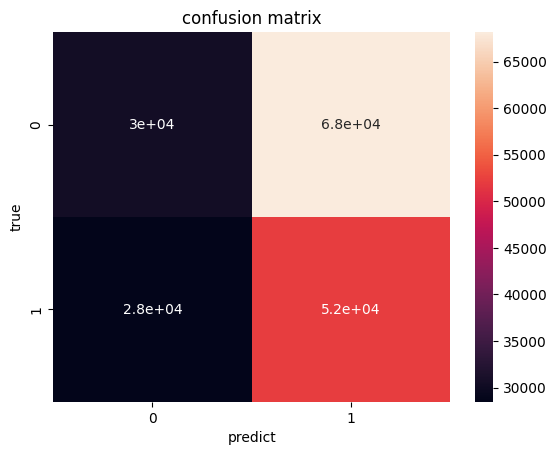

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111)
conf_mat = confusion_matrix(relate['tag'], relate['pred'])
sns.heatmap(conf_mat,annot=True,xticklabels=['0','1'],yticklabels=['0','1']) 
ax.set_title('confusion matrix') 
ax.set_xlabel('predict')
ax.set_ylabel('true') 
plt.savefig('covid confusion matrix')
plt.show()
